#**PROJECT**
##DATA SCIENCE TOOLS AND TECHNIQUES

###**<span style='text-decoration:underline;'>STUDENT INFO</span>**
<br>

###**Name: M. Fouzan Asif**
###**NU-ID: 23K-8054**
###**Section: MDS-3B**
###**Semester: Fall 2023**

## **DATASET DESCRIPTION**

the NGA-West2 and NGA-East dataset is a widely used collection of ground motion prediction equations (GMPEs) developed for seismic hazard analysis. It provides equations and models to estimate ground motions (such as peak ground acceleration, peak ground velocity, and response spectra) caused by earthquakes at various sites.

NGA-West2 stands for Next Generation Attenuation for Western United States, and it's an extension of the original NGA-West dataset. Similarly, the NGA-East dataset focuses more on Eastern United States. It includes a broader geographic region and additional ground motion records from earthquakes worldwide.

The dataset was developed by a collaboration of researchers and experts in earthquake engineering and seismology. It incorporates a large amount of strong motion data from various earthquakes and serves as a valuable resource for seismic hazard assessment and engineering applications.

Researchers and engineers use the NGA-West2 models to estimate ground motions at specific sites for seismic risk assessment, structural design, and earthquake-resistant infrastructure development. The dataset is frequently referenced in earthquake engineering studies, seismic hazard analyses, and building code development.

In my project, I have used NGA-West2's tabular extract available at PEER's website https://apps.peer.berkeley.edu/peer_gmd_ngaw2/APPENDIX_B-1_Records_in_PGMD.xls . A detailed study of NGA-West2 research project is available at https://sci-hub.yncjkj.com/10.1193/072113eqs209m.

##**Step 0: LIBRARY IMPORTS AND HELPER FUNCTIONS**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import cross_val_predict, KFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,
    BaggingClassifier, ExtraTreesClassifier, VotingClassifier
)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [ ]:
# Global Variables

features = ['Record Sequence Number', 'YEAR', 'MODY', 'Station Name', 'Earthquake Magnitude', 'Closest Distance* (km)', 'Excluded']
categorical_cols = ['Station Name', 'Excluded']
numerical_cols = ['Earthquake Magnitude', 'Closest Distance* (km)', 'Preferred Vs30** (m/s)', 'MODY']
taiwan, canada, rof = None, None, None
# Helper functions

def encode(df2):
  global categorical_cols
  encoder = LabelEncoder()
  for col in categorical_cols:
      df2[col] = encoder.fit_transform(df[col].astype(str))
  return df2

def Vs_boxplots(df):
  plt.figure(figsize=(8, 6))
  plt.boxplot(df['Preferred Vs30** (m/s)'].dropna(), vert=False)
  plt.title('Distribution of Preferred Vs30** (m/s)')
  plt.xlabel('Vs30** (m/s)')
  plt.show()
  return

def load_data():
  global taiwan, canada, rof
  spreadsheet_id = "1t7Cuv-taDg1KMpnW2kH1LzYXHkJ3UhcpspN0ErWBLx8"
  all_data = "Dataset"
  taiwan, canada, rof = "Taiwan", "China", "Others"
  df = pd.read_csv(f"https://docs.google.com/spreadsheets/d/{spreadsheet_id}/gviz/tq?tqx=out:csv&sheet={all_data}")
  taiwan = pd.read_csv(f"https://docs.google.com/spreadsheets/d/{spreadsheet_id}/gviz/tq?tqx=out:csv&sheet={taiwan}")
  canada = pd.read_csv(f"https://docs.google.com/spreadsheets/d/{spreadsheet_id}/gviz/tq?tqx=out:csv&sheet={canada}")
  rof = pd.read_csv(f"https://docs.google.com/spreadsheets/d/{spreadsheet_id}/gviz/tq?tqx=out:csv&sheet={rof}")
  return df

def impute_using_NaiveBayes(df):
  global features, categorical_cols

  df2 = df.copy()
  df2 = encode(df2)

  complete_data = df2.dropna(subset=['Fault Type', 'FW/HW Indicator***'])
  incomplete_data = df2[df2['Fault Type'].isnull() | df2['FW/HW Indicator***'].isnull()]

  verification_indexes = list(incomplete_data[incomplete_data['Fault Type'].isnull() | df2['FW/HW Indicator***'].isnull()]['Record Sequence Number'].values)

  for col in ['Fault Type', 'FW/HW Indicator***']:
      X_train = complete_data[features]
      y_train = complete_data[col]

      model = GaussianNB()
      model.fit(X_train, y_train)

      X_incomplete = incomplete_data[features]
      imputer = SimpleImputer()
      X_incomplete = imputer.fit_transform(X_incomplete)
      predicted_values = model.predict(X_incomplete)

      incomplete_data[col] = predicted_values

  return incomplete_data, verification_indexes

def impute_by_RandomForest(df):
  global categorical_cols, features

  categorical_cols = ['Station Name', 'Excluded']

  df2 = df.copy()
  df2 = encode(df2)

  complete_data = df2.dropna(subset=['Fault Type', 'Preferred Vs30** (m/s)', 'FW/HW Indicator***'])
  incomplete_data = df2[df2['Fault Type'].isnull() | df2['Preferred Vs30** (m/s)'].isnull() | df2['FW/HW Indicator***'].isnull()]

  verification_indexes = list(incomplete_data[incomplete_data['Fault Type'].isnull() | df2['FW/HW Indicator***'].isnull() | df2['Preferred Vs30** (m/s)'].isnull()]['Record Sequence Number'].values)
  target_cols = ['Fault Type', 'Preferred Vs30** (m/s)', 'FW/HW Indicator***']

  for col in target_cols:
    X_train = complete_data[features]
    y_train = complete_data[col]

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    imputer = SimpleImputer()
    incomplete_data[features] = imputer.fit_transform(incomplete_data[features])
    predicted_values = model.predict(incomplete_data[features])

    incomplete_data[col] = predicted_values
  return incomplete_data, verification_indexes

def Numerical_BoxPlots(df):
  numerical_cols = ['Earthquake Magnitude', 'Closest Distance* (km)', 'Preferred Vs30** (m/s)', 'MODY']
  plt.figure(figsize=(10, 8))
  for i, col in enumerate(numerical_cols, 1):
      plt.subplot(2, 2, i)
      sns.boxplot(y=df[col], color='skyblue')
      plt.title(f'Boxplot of {col}')
  plt.tight_layout()
  plt.show()

def StandardTransformation(df):
  global numerical_cols
  for i in numerical_cols[1:3]:
    scaler = StandardScaler()
    df[i] = scaler.fit_transform(df[[i]])
  return df

def Numerical_LogTransformation(df):
  global numerical_cols
  for i in numerical_cols[1:4]:
    df[i] = np.log1p(df[i])
  return df

def Numerical_MinMaxTransform(df):
  global numerical_cols
  for i in numerical_cols[1:4]:
    scaler = MinMaxScaler()
    df[i] = scaler.fit_transform(df[[i]])
  return df

def Numerical_StandardTransform(df):
  global numerical_cols
  for i in numerical_cols[1:4]:
    scaler = StandardScaler()
    df[i] = scaler.fit_transform(df[[i]])
  return df

df = load_data()

###Dataset review (12 columns)

In [ ]:
df.head()

,Record Sequence Number,Earthquake Name,YEAR,MODY,Station Name,Earthquake Magnitude,Fault Type,Closest Distance* (km),Preferred Vs30** (m/s),FW/HW Indicator***,Excluded
0,12,Kern County,1952,721,LA - Hollywood Stor FF,7.36,RV,118.0,316.0,na,No
1,23,San Francisco,1957,322,Golden Gate Park,5.28,RV,11.0,874.0,NaN,No
2,28,Parkfield,1966,628,Cholame - Shandon Array #12,6.19,SS,17.6,409.0,na,No
3,30,Parkfield,1966,628,Cholame - Shandon Array #5,6.19,SS,9.6,290.0,na,No
4,31,Parkfield,1966,628,Cholame - Shandon Array #8,6.19,SS,12.9,257.0,na,No


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3551 entries, 0 to 3550
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Record Sequence Number  3551 non-null   int64  
 1   Earthquake Name         3551 non-null   object 
 2   YEAR                    3551 non-null   int64  
 3   MODY                    3551 non-null   int64  
 4   Station Name            3551 non-null   object 
 5   Earthquake Magnitude    3551 non-null   float64
 6   Fault Type              3466 non-null   object 
 7   Closest Distance* (km)  3551 non-null   float64
 8   Preferred Vs30** (m/s)  2418 non-null   float64
 9   FW/HW Indicator***      3173 non-null   object 
 10  Excluded                3551 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 305.3+ KB


##**Step 1: DATA VISUALIZATION**

### Null value counts and Patterns

,Null Counts,Null Percentage
Record Sequence Number,0,0.000000
Earthquake Name,0,0.000000
YEAR,0,0.000000
MODY,0,0.000000
Station Name,0,0.000000
Earthquake Magnitude,0,0.000000
Fault Type,85,2.393692
Closest Distance* (km),0,0.000000
Preferred Vs30** (m/s),1133,31.906505
FW/HW Indicator***,378,10.644889


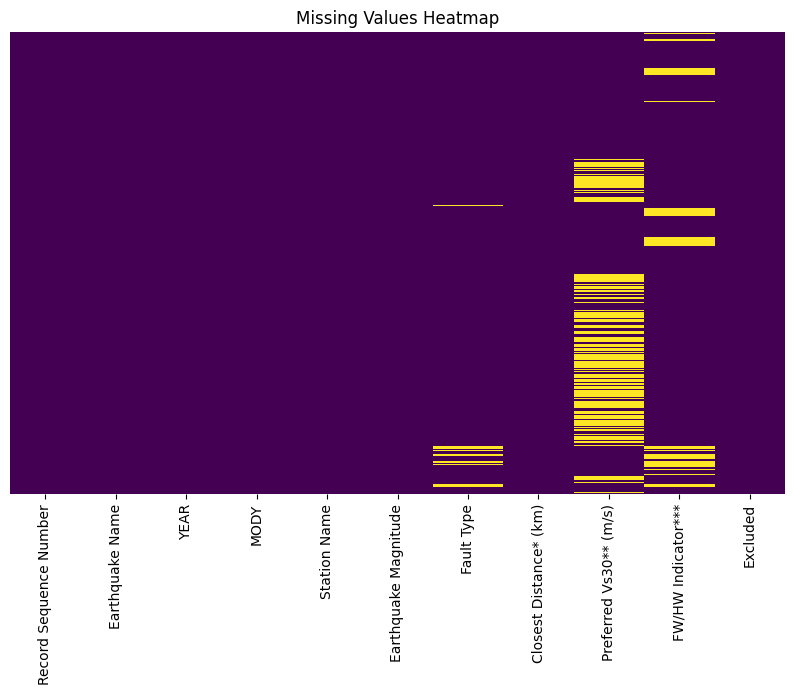

In [ ]:
null_counts = df.isnull().sum()
null_percentage = (null_counts / len(df)) * 100
null_info = pd.DataFrame({'Null Counts': null_counts, 'Null Percentage': null_percentage})
display(null_info)

plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cmap='viridis', yticklabels=False, cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

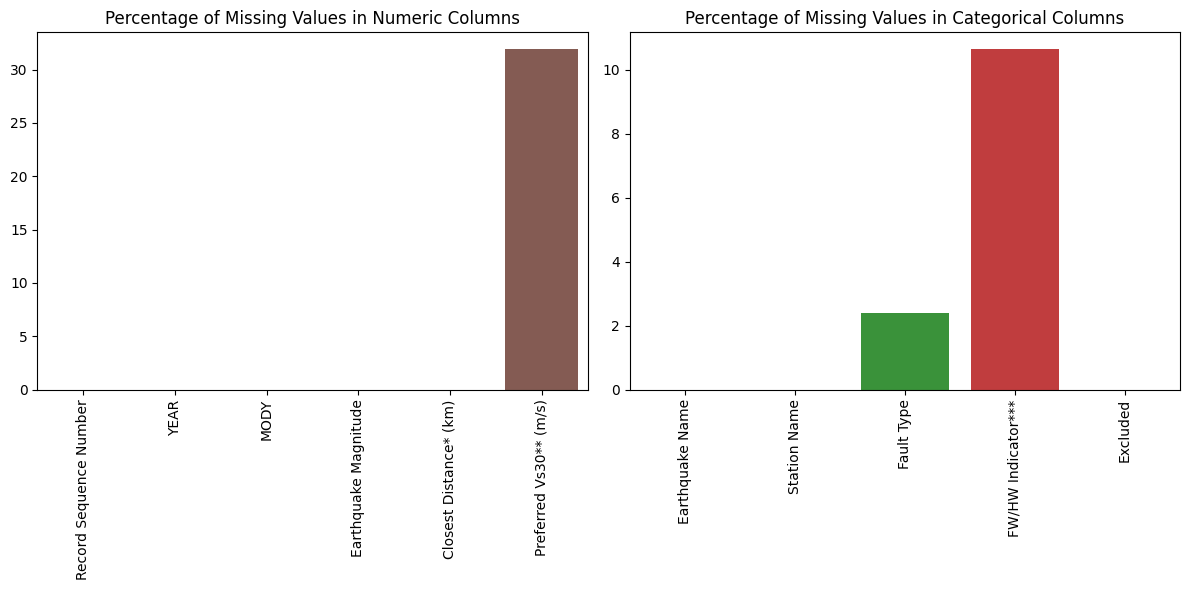

In [ ]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=null_percentage[numeric_cols].index, y=null_percentage[numeric_cols])
plt.title('Percentage of Missing Values in Numeric Columns')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.barplot(x=null_percentage[categorical_cols].index, y=null_percentage[categorical_cols])
plt.title('Percentage of Missing Values in Categorical Columns')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

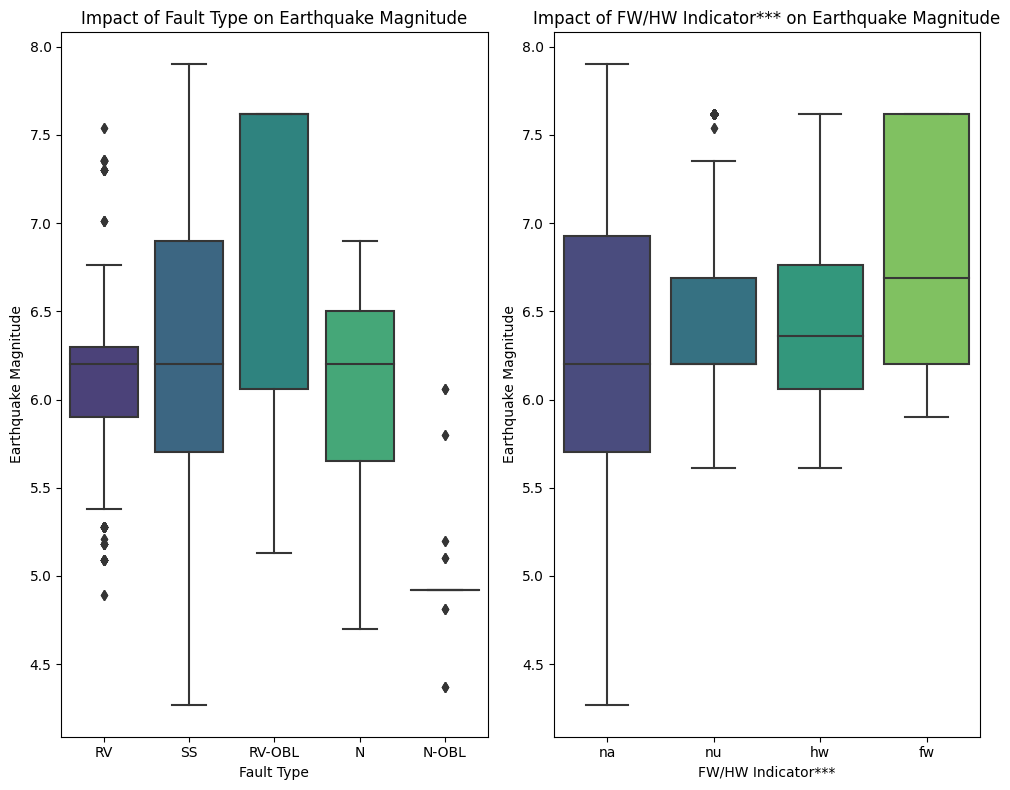

In [ ]:
columns_with_missing = ['Fault Type', 'FW/HW Indicator***']

plt.figure(figsize=(10, 8))

for i, column in enumerate(columns_with_missing, 1):
    plt.subplot(1, len(columns_with_missing), i)
    sns.boxplot(x=column, y='Earthquake Magnitude', data=df, orient='v', palette='viridis')
    plt.title(f'Impact of {column} on Earthquake Magnitude')

plt.tight_layout()
plt.show()


<ipython-input-44-e57ae2928f2c>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[i], label=i, shade=True)


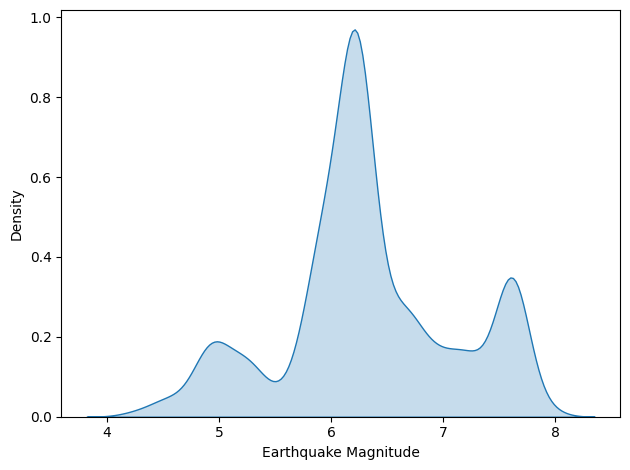

<ipython-input-44-e57ae2928f2c>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[i], label=i, shade=True)


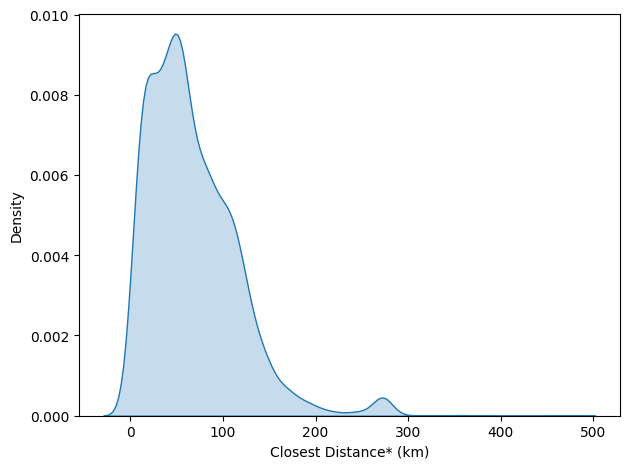

<ipython-input-44-e57ae2928f2c>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[i], label=i, shade=True)


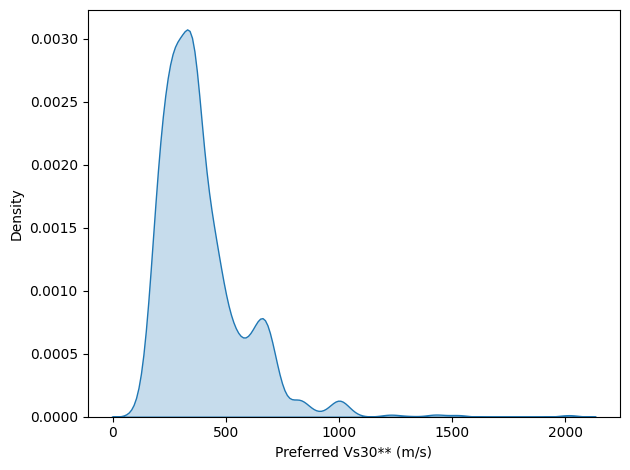

<ipython-input-44-e57ae2928f2c>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[i], label=i, shade=True)


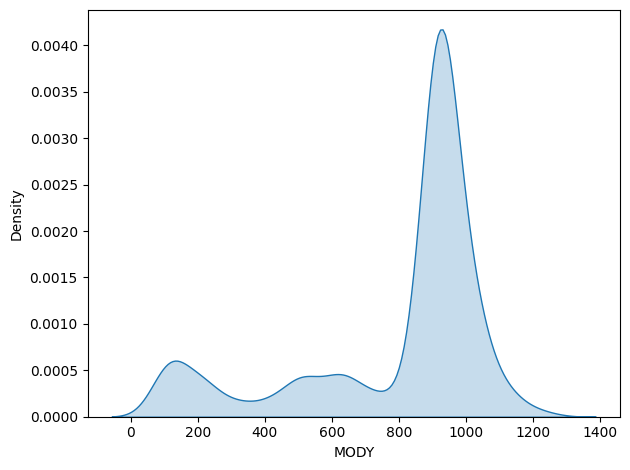

In [ ]:
for i in numerical_cols:
  sns.kdeplot(df[i], label=i, shade=True)
  plt.tight_layout()
  plt.show()

Given the above distributions and empty data pattern, we know that the missing entries are disjoint samples. Since there may persist an issue for independence between the variables, imputation of data has to be done wisely.



##**Step 2: DATA CLEANING**

###VISUALIZING THE COLUMN WITH MISSING ENTRIES

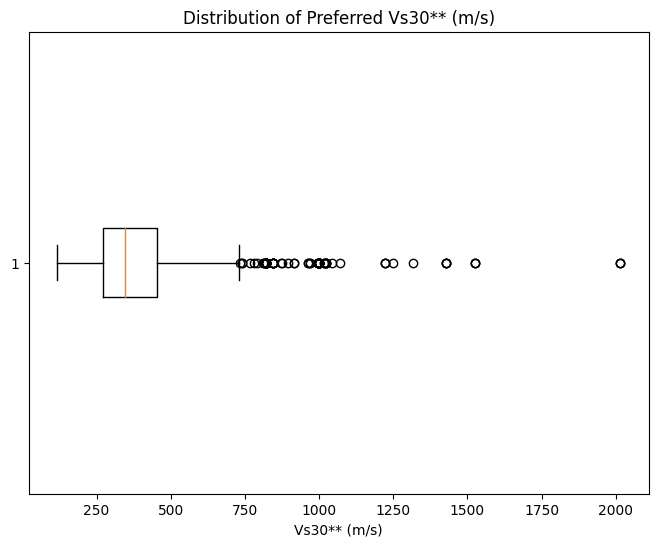

In [ ]:
# BEFORE FIXING THE DATA

Vs_boxplots(df)

###IMPUTING THE DATA USING RANDOM FOREST

In [ ]:
fixed_data, empty_indexes = impute_by_RandomForest(df)

<ipython-input-38-6e20fe06fba3>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  verification_indexes = list(incomplete_data[incomplete_data['Fault Type'].isnull() | df2['FW/HW Indicator***'].isnull() | df2['Preferred Vs30** (m/s)'].isnull()]['Record Sequence Number'].values)
<ipython-input-38-6e20fe06fba3>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incomplete_data[features] = imputer.fit_transform(incomplete_data[features])
<ipython-input-38-6e20fe06fba3>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [ ]:
display(fixed_data[fixed_data['Record Sequence Number'].isin(empty_indexes) & fixed_data['Fault Type'] != 'SS'])

,Record Sequence Number,Earthquake Name,YEAR,MODY,Station Name,Earthquake Magnitude,Fault Type,Closest Distance* (km),Preferred Vs30** (m/s),FW/HW Indicator***,Excluded
1,23.0,San Francisco,1957.0,322.0,408.0,5.28,SS,11.0,213.0,na,0.0
8,41.0,Lytle Creek,1970.0,912.0,266.0,5.33,SS,104.0,275.0,na,0.0
9,42.0,Lytle Creek,1970.0,912.0,267.0,5.33,SS,22.6,219.0,na,0.0
10,43.0,Lytle Creek,1970.0,912.0,268.0,5.33,SS,19.2,219.0,na,0.0
11,44.0,Lytle Creek,1970.0,912.0,287.0,5.33,SS,30.0,339.0,na,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3539,2802.0,"Chi-Chi, Taiwan-04",1999.0,920.0,470.0,6.20,SS,91.0,511.0,na,18.0
3540,3041.0,"Chi-Chi, Taiwan-05",1999.0,922.0,470.0,6.20,RV,56.0,511.0,nu,18.0
3543,3191.0,"Chi-Chi, Taiwan-05",1999.0,922.0,1274.0,6.20,RV,101.0,429.0,nu,6.0
3544,3364.0,"Chi-Chi, Taiwan-06",1999.0,925.0,470.0,6.30,RV,56.0,511.0,nu,18.0


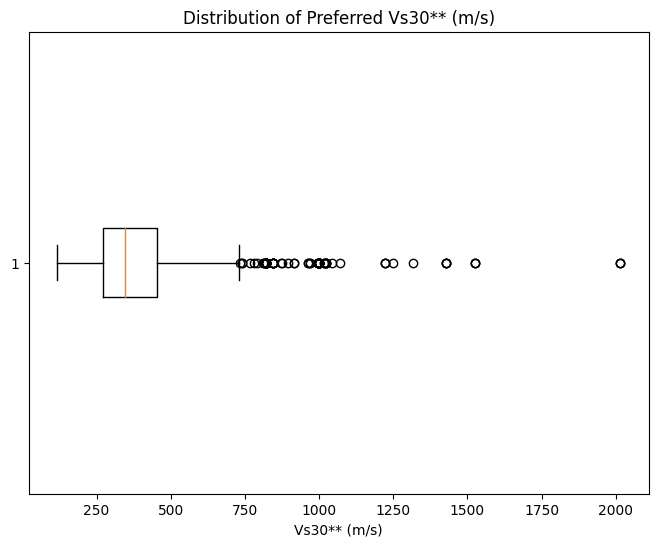

In [ ]:
# AFTER FIXING THE DATA

Vs_boxplots(df)

In [ ]:
df2 = df.copy()
df = df.combine_first(fixed_data)

### **OUTLIER TREATMENT (USING LINEAR TRANSFORMATION)**

#### Initial Box Plots

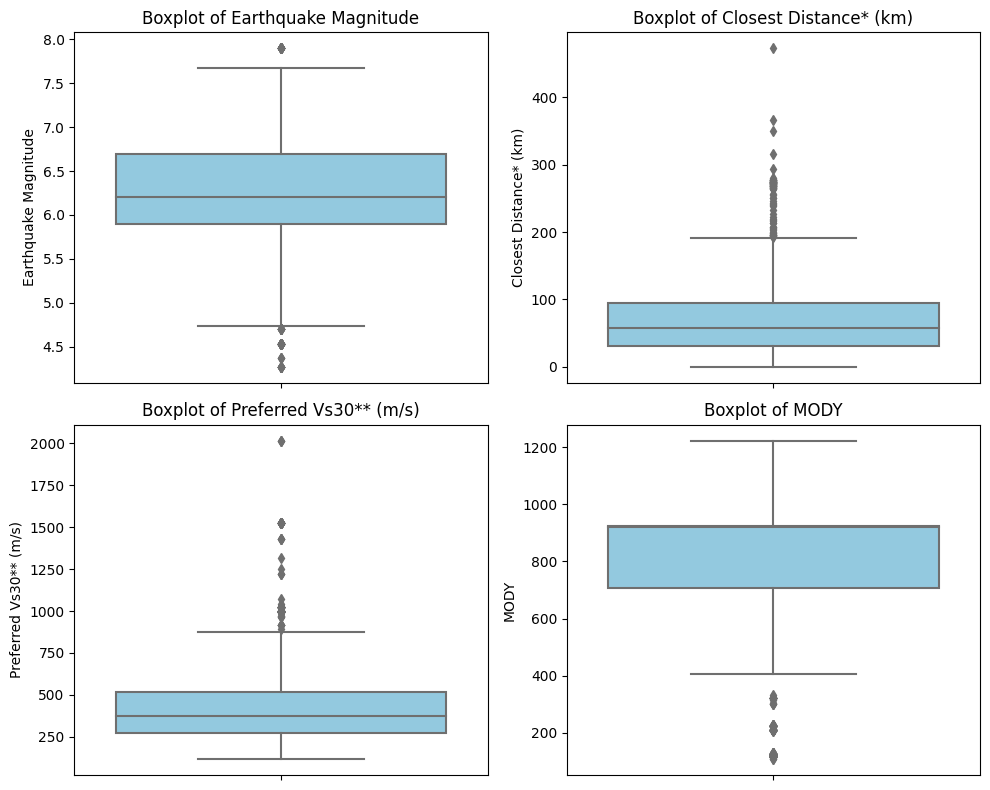

In [ ]:
df3 = df.copy()
Numerical_BoxPlots(df)

#### Log Transformed Data Box Plots (not over Earthquake Magnitude)

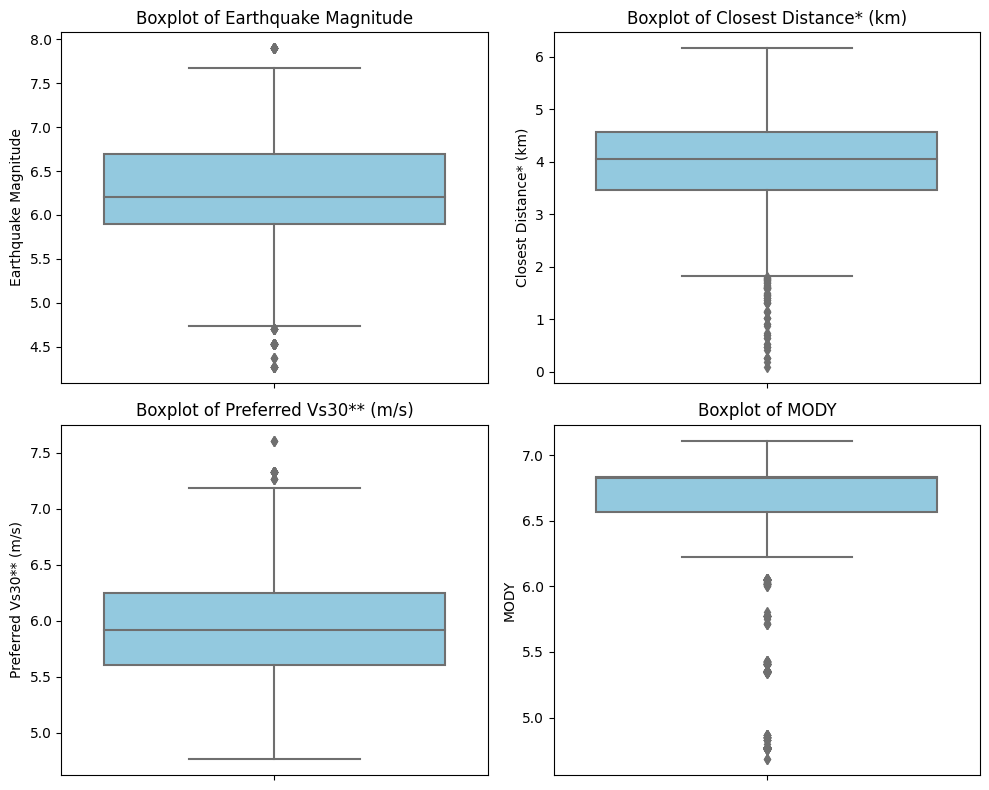

In [ ]:
df2 = Numerical_LogTransformation(df)
Numerical_BoxPlots(df2)

#### Using MinMax Transformation

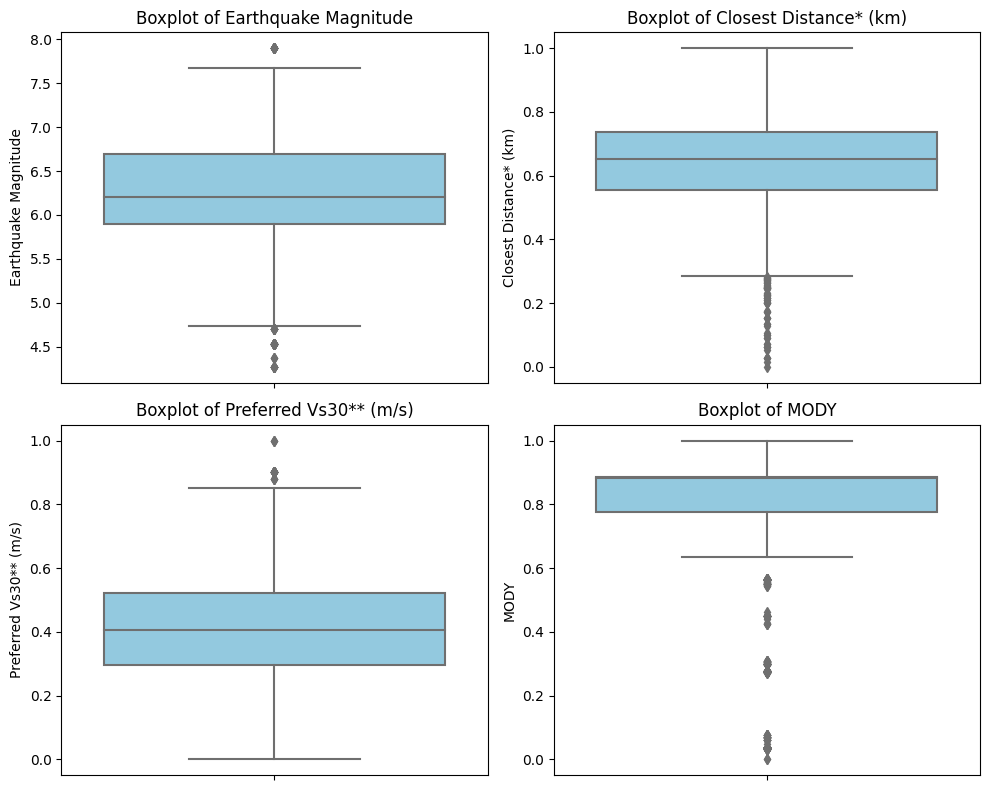

In [ ]:
df2 = Numerical_MinMaxTransform(df)
Numerical_BoxPlots(df2)

#### Using Standard (z or Normal distribution) transformation

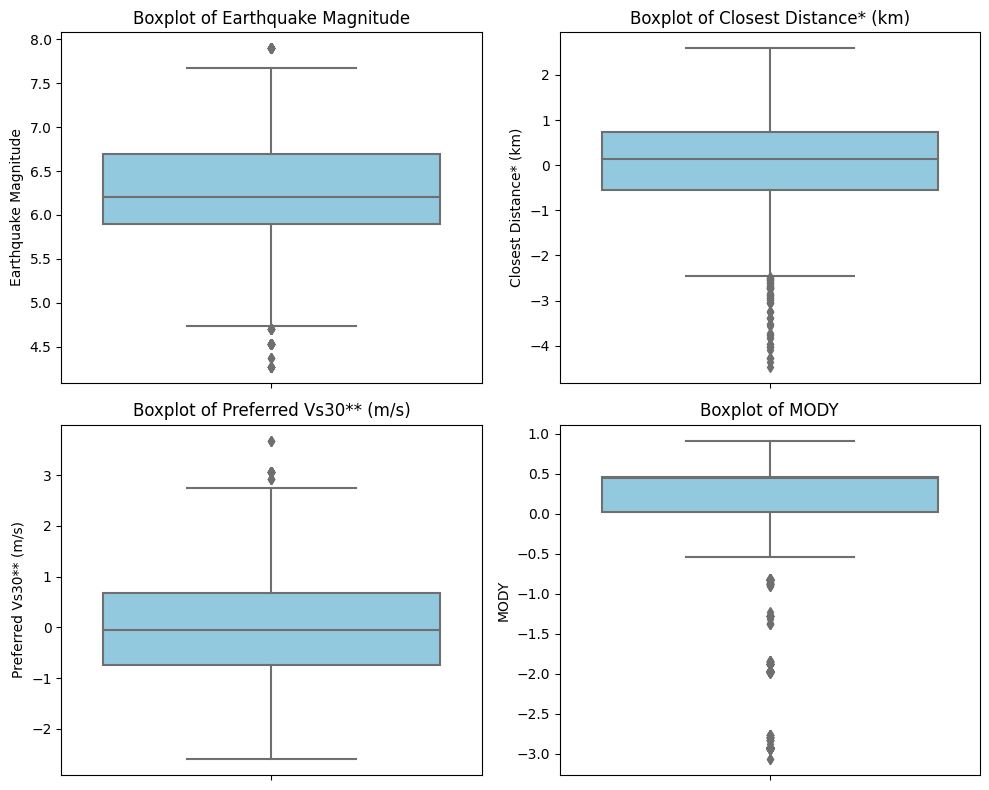

In [ ]:
df2 = Numerical_StandardTransform(df)
Numerical_BoxPlots(df2)

Here, we conclude that we cannot transform MODY in any case as that only worsens the case. And Earthquake magnitude is highly sensitive attribute. Thus, we'll only transform the other 2 attributes.

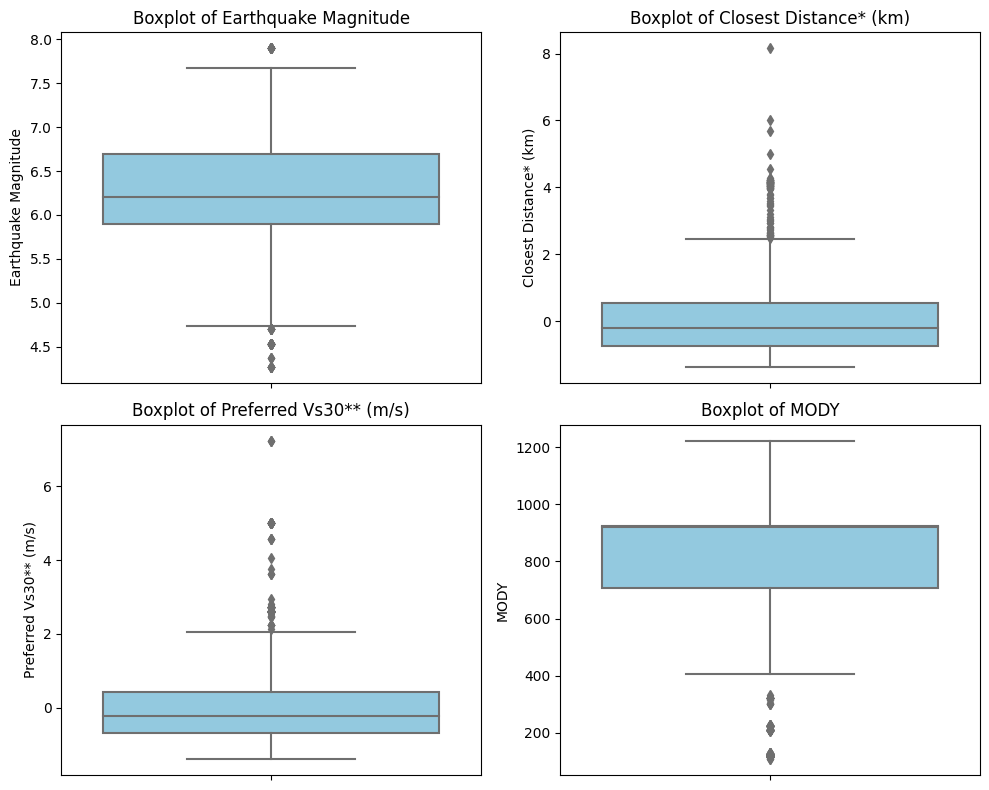

In [ ]:
df = df3.copy()
df = StandardTransformation(df)
Numerical_BoxPlots(df)

### **REMOVING REMAINING OUTLIERS**

In [ ]:
Q1 = df['Preferred Vs30** (m/s)'].quantile(0.25)
Q3 = df['Preferred Vs30** (m/s)'].quantile(0.75)
IQR = Q3 - Q1

df = df[(df['Preferred Vs30** (m/s)'] >= Q1 - 1.5 * IQR) & (df['Preferred Vs30** (m/s)'] <= Q3 + 1.5 * IQR)]

Q1 = df['Closest Distance* (km)'].quantile(0.25)
Q3 = df['Closest Distance* (km)'].quantile(0.75)
IQR = Q3 - Q1

df = df[(df['Closest Distance* (km)'] >= Q1 - 1.5 * IQR) & (df['Closest Distance* (km)'] <= Q3 + 1.5 * IQR)]

### **DERIVING A NEW RELATION**

Given Earthquake Magnitude and the Closest Distance (from the epicenter) and the velocity of the waves, we can derive the distance interaction which may serve in determining the damage when combined with data that demonstrates damage.

In [ ]:
df['Strength'] = df['Earthquake Magnitude'] * df['Closest Distance* (km)']
df['Intensity'] = df['Earthquake Magnitude'] * df['Preferred Vs30** (m/s)']

### **DATA TRANSFORMATION**

In [ ]:
pivot_station_name = df.pivot_table(index='Station Name', aggfunc='median')
pivot_station_name

<ipython-input-57-77d3b07996c9>:1: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  pivot_station_name = df.pivot_table(index='Station Name', aggfunc='median')


,Closest Distance* (km),Earthquake Magnitude,Intensity,MODY,Preferred Vs30** (m/s),Record Sequence Number,Strength,YEAR
Station Name,,,,,,,,
"12440 Imperial Hwy, North Grn",2.199770,7.13,-4.785477,1016.0,-0.671175,1759.0,15.684357,1999.0
2516 Via Tejon PV,-0.256118,6.61,-4.256360,209.0,-0.643927,51.0,-1.692937,1971.0
ALP (temp),-0.805673,5.09,-1.081670,509.0,-0.212509,370.0,-4.100873,1983.0
ALS,-1.145873,7.62,4.505644,920.0,0.591292,1178.0,-8.731555,1999.0
ANL-767 Reactor Plant (Bsmt),0.649742,6.88,7.411172,1028.0,1.077205,434.0,4.470228,1983.0
...,...,...,...,...,...,...,...,...
Yermo Fire Station,0.025706,6.46,-2.018209,628.0,-0.312416,941.0,0.116446,1992.0
Yucaipa Valley - Calimesa & Cnty,-0.698982,4.53,-1.065524,210.0,-0.235215,1910.0,-3.166390,2001.0
Zack Brothers Ranch,-1.180095,5.71,-3.936130,721.0,-0.689340,559.5,-6.689104,1986.0


In [ ]:
pivot_year = df.pivot_table(index='YEAR', aggfunc='median')
pivot_year

<ipython-input-58-7fd40f46850f>:1: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  pivot_year = df.pivot_table(index='YEAR', aggfunc='median')


,Closest Distance* (km),Earthquake Magnitude,Intensity,MODY,Preferred Vs30** (m/s),Record Sequence Number,Strength
YEAR,,,,,,,
1935.0,-1.304902,6.000,6.463232,1031.0,1.077205,1.5,-7.829413
1937.0,0.086096,5.800,-5.367811,207.0,-0.925485,3.0,0.499358
1938.0,-0.467485,5.250,-4.926913,759.0,-0.939108,4.5,-2.406486
1940.0,-1.240485,6.950,-6.621488,519.0,-0.952732,6.0,-8.621373
1941.0,0.005575,6.500,-6.015650,606.0,-0.925485,7.5,0.082539
1942.0,-0.215857,6.500,-6.192759,1021.0,-0.952732,9.0,-1.403071
1951.0,-0.566123,5.700,-5.351556,566.0,-0.939108,10.5,-3.197913
1952.0,0.196812,7.360,-0.761899,721.0,-0.103519,14.5,1.376306
1953.0,-1.049248,5.500,-5.240027,614.0,-0.952732,18.0,-5.770865


More useful transformations will be part of EDA

### **LINEAR TRANSFORMATION**

Having seen that we now have a total of 14 attributes, let's reduce some dimensions of independent features (least correlated features to capture maximum variance)

<ipython-input-59-22c33e2d0e74>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


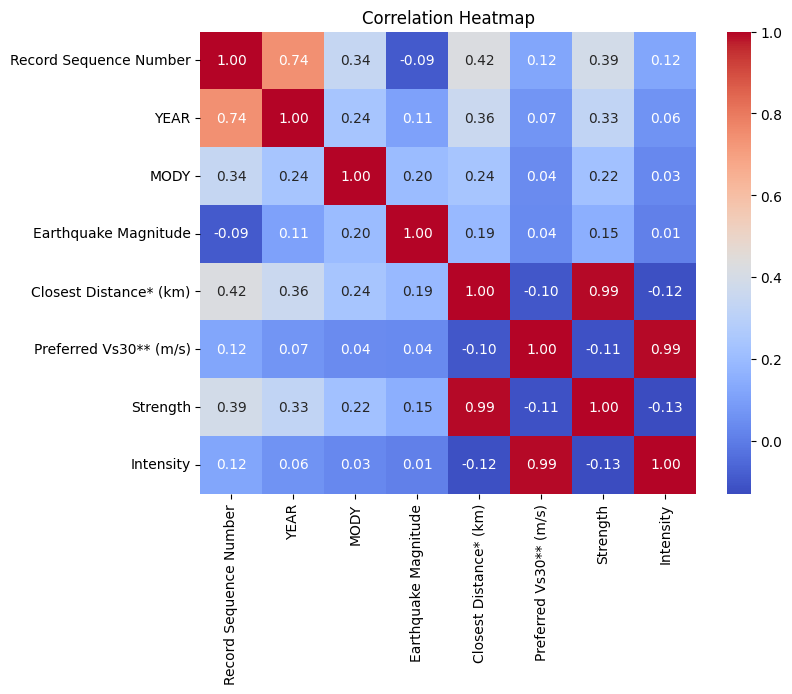

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

We see that Closest Distance, Preferred Vs, Strength, and Intensity are mostly independent of other features but closely correlated themselves.
Let's try to reduce the dimensions using PCA/

In [ ]:
df2 = df.copy()

df2.head()

,Record Sequence Number,Earthquake Name,YEAR,MODY,Station Name,Earthquake Magnitude,Fault Type,Closest Distance* (km),Preferred Vs30** (m/s),FW/HW Indicator***,Excluded,Strength,Intensity
0,12.0,Kern County,1952.0,721.0,LA - Hollywood Stor FF,7.36,RV,1.012086,-0.484984,na,No,7.448956,-3.569480
1,23.0,San Francisco,1957.0,322.0,Golden Gate Park,5.28,RV,-1.141847,2.049032,na,No,-6.028954,10.818890
2,28.0,Parkfield,1966.0,628.0,Cholame - Shandon Array #12,6.19,SS,-1.008988,-0.062648,na,No,-6.245635,-0.387789
3,30.0,Parkfield,1966.0,628.0,Cholame - Shandon Array #5,6.19,SS,-1.170030,-0.603056,na,No,-7.242483,-3.732917
4,31.0,Parkfield,1966.0,628.0,Cholame - Shandon Array #8,6.19,SS,-1.103600,-0.752917,na,No,-6.831283,-4.660558


#### PRINCIPLE COMPONENT ANALYSIS

From here onwards, our dataframe will be called data instead of df

<ipython-input-61-dd2a2cfb75b7>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['Preferred Vs30** (m/s)'], label='Preferred Vs30** (m/s)', shade=True)
<ipython-input-61-dd2a2cfb75b7>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['Closest Distance* (km)'], label='Closest Distance* (km)', shade=True)
<ipython-input-61-dd2a2cfb75b7>:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['MODY'], label='MODY', shade=True)
<ipython-input-61-dd2a2cfb75b7>:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

 

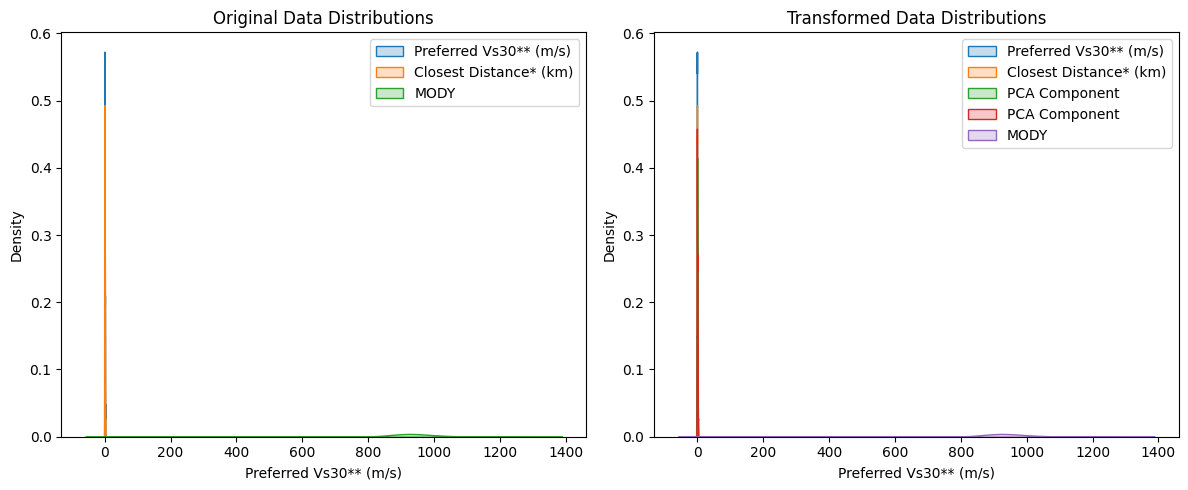

In [ ]:
data = df2[['Preferred Vs30** (m/s)', 'Closest Distance* (km)', 'Earthquake Magnitude','MODY']].dropna()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.kdeplot(data['Preferred Vs30** (m/s)'], label='Preferred Vs30** (m/s)', shade=True)
sns.kdeplot(data['Closest Distance* (km)'], label='Closest Distance* (km)', shade=True)
sns.kdeplot(data['MODY'], label='MODY', shade=True)
plt.title('Original Data Distributions')
plt.legend()

# Transformed Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[['Preferred Vs30** (m/s)', 'Closest Distance* (km)', 'MODY']])
pca = PCA(n_components=2)
X_pca1 = pca.fit_transform(X_scaled)

data['PCA_Component1'] = X_pca1[:,0]
data['PCA_Component2'] = X_pca1[:,1]

plt.subplot(1, 2, 2)
sns.kdeplot(data['Preferred Vs30** (m/s)'], label='Preferred Vs30** (m/s)', shade=True)
sns.kdeplot(data['Closest Distance* (km)'], label='Closest Distance* (km)', shade=True)
sns.kdeplot(data['PCA_Component1'], label='PCA Component', shade=True)
sns.kdeplot(data['PCA_Component2'], label='PCA Component', shade=True)
sns.kdeplot(data['MODY'], label='MODY', shade=True)
plt.title('Transformed Data Distributions')
plt.legend()

plt.tight_layout()
plt.show()

data.drop(columns=['Preferred Vs30** (m/s)', 'Closest Distance* (km)', 'MODY'],inplace=True)

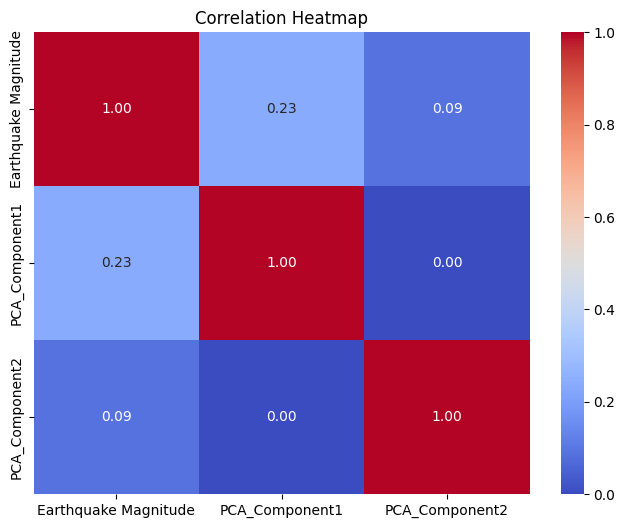

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

## **Step 3: EXPLORATORY DATA ANALYSIS (Extended)**

#### DATA DISTRIBUTIONS

<ipython-input-63-80e5d7ad2fc1>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


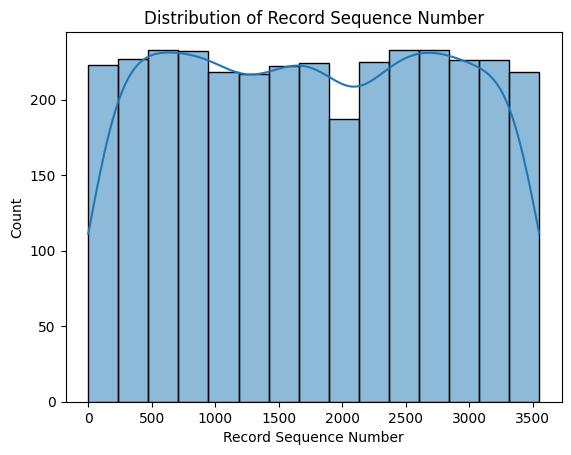

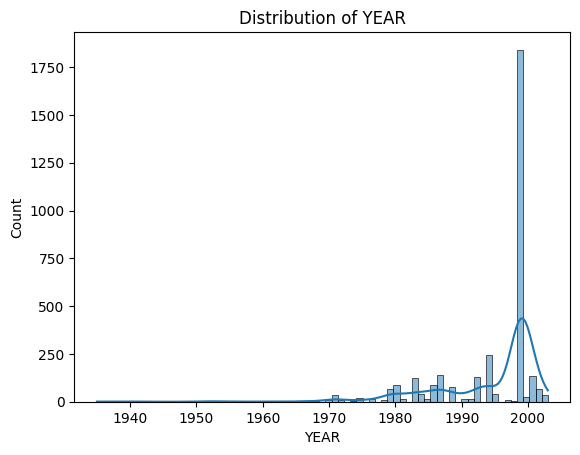

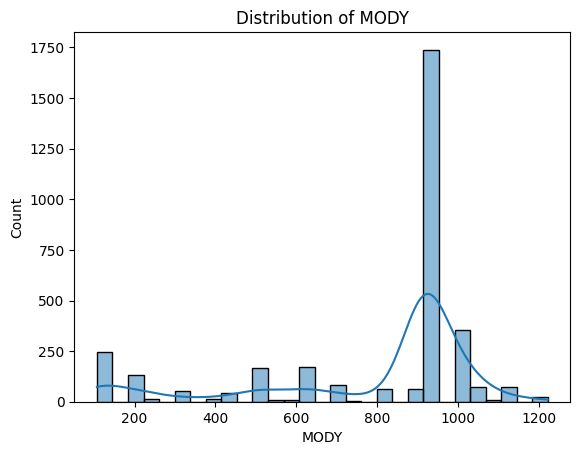

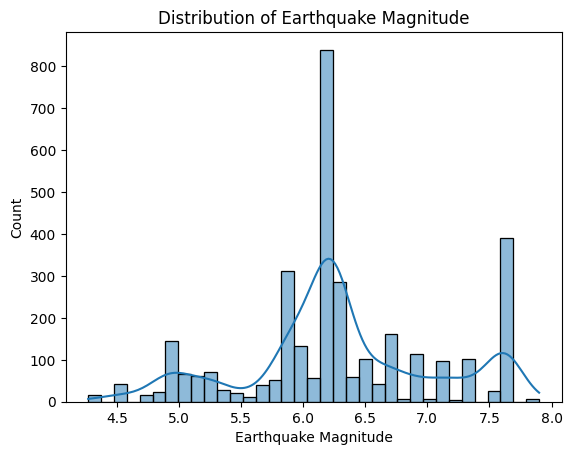

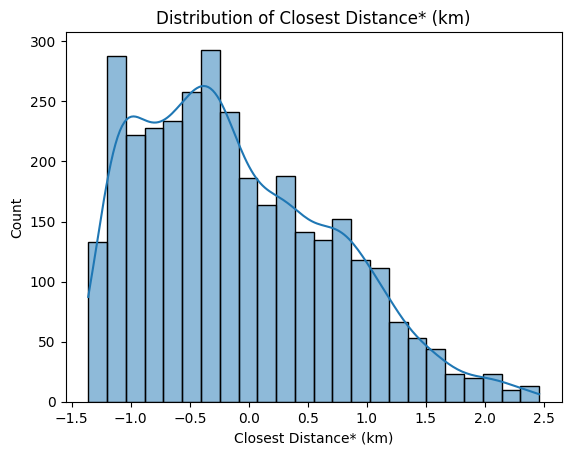

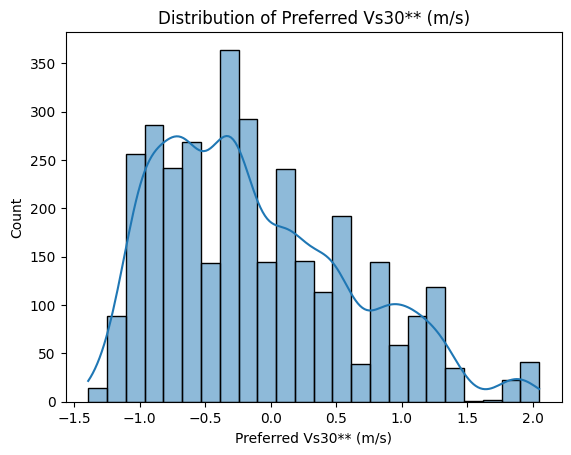

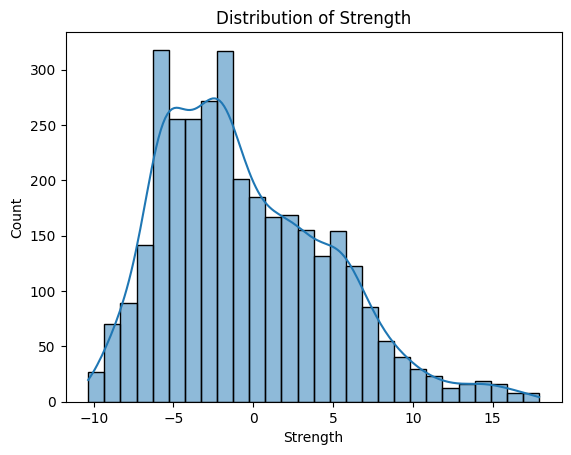

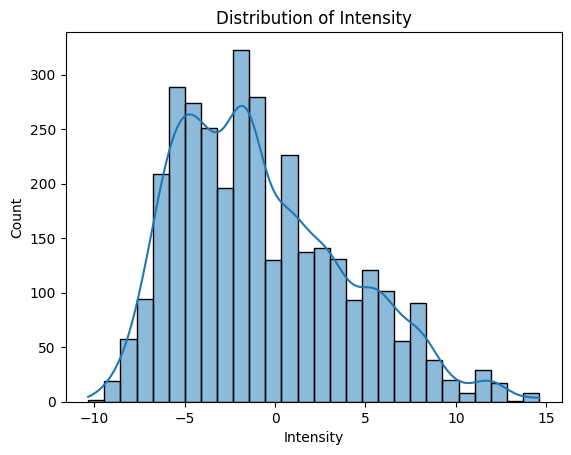

Correlation Matrix:
                        Record Sequence Number      YEAR      MODY  \
Record Sequence Number                1.000000  0.739897  0.341905   
YEAR                                  0.739897  1.000000  0.238296   
MODY                                  0.341905  0.238296  1.000000   
Earthquake Magnitude                 -0.093478  0.107225  0.199698   
Closest Distance* (km)                0.422801  0.360189  0.240911   
Preferred Vs30** (m/s)                0.119183  0.066930  0.039072   
Strength                              0.391178  0.327693  0.220768   
Intensity                             0.118441  0.064177  0.032595   

                        Earthquake Magnitude  Closest Distance* (km)  \
Record Sequence Number             -0.093478                0.422801   
YEAR                                0.107225                0.360189   
MODY                                0.199698                0.240911   
Earthquake Magnitude                1.000000                0

Record Sequence Number    0.007005
YEAR                     -2.239934
MODY                     -1.349421
Earthquake Magnitude     -0.015581
Closest Distance* (km)    0.603575
Preferred Vs30** (m/s)    0.681291
Strength                  0.717601
Intensity                 0.662845
dtype: float64


Kurtosis of Numerical Columns:


Record Sequence Number   -1.223752
YEAR                      7.328932
MODY                      0.539216
Earthquake Magnitude     -0.164831
Closest Distance* (km)   -0.297389
Preferred Vs30** (m/s)   -0.238730
Strength                  0.198199
Intensity                -0.131570
dtype: float64

In [ ]:
corr_matrix = df.corr()

num_columns =  df.select_dtypes(include=['float64']).columns.tolist()
#num_columns.append('YEAR')
for col in num_columns:
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

skewness = df[num_columns].skew()
kurtosis = df[num_columns].kurtosis()

print("Correlation Matrix:")
print(corr_matrix)

print("\nSkewness of Numerical Columns:")
display(skewness)

print("\nKurtosis of Numerical Columns:")
display(kurtosis)


#### STATISTICAL FINDINGS

In [ ]:
import pandas as pd

numerical_columns = df.select_dtypes(include=['float64', 'int64']).drop(['YEAR', 'Record Sequence Number'], axis=1).columns

stats_dict = {
    'Mean': df[numerical_columns].mean(),
    'Median': df[numerical_columns].median(),
    'Mode': df[numerical_columns].mode().iloc[0],  # Mode can have multiple values, taking the first one
    'Standard Deviation': df[numerical_columns].std(),
    'Variance': df[numerical_columns].var(),
    'Skewness': df[numerical_columns].skew(),
    'Kurtosis': df[numerical_columns].kurtosis()
}

stats_df = pd.DataFrame(stats_dict)
print(stats_df)


                              Mean      Median        Mode  \
MODY                    787.233852  920.000000  920.000000   
Earthquake Magnitude      6.286896    6.200000    6.200000   
Closest Distance* (km)   -0.092912   -0.235987   -0.276248   
Preferred Vs30** (m/s)   -0.123318   -0.235215   -0.380535   
Strength                 -0.465871   -1.486720   -1.463121   
Intensity                -0.754111   -1.600393    2.962116   

                        Standard Deviation      Variance  Skewness  Kurtosis  
MODY                            280.649250  78764.001534 -1.349421  0.539216  
Earthquake Magnitude              0.767603      0.589215 -0.015581 -0.164831  
Closest Distance* (km)            0.816998      0.667486  0.603575 -0.297389  
Preferred Vs30** (m/s)            0.728622      0.530890  0.681291 -0.238730  
Strength                          5.254058     27.605126  0.717601  0.198199  
Intensity                         4.638379     21.514555  0.662845 -0.131570  


#### PAIR PLOTS AND SCATTER PLOTS

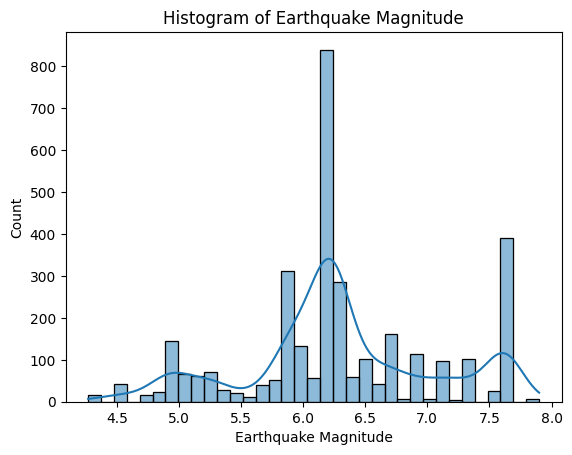

<ipython-input-66-d84437b2a921>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df['Preferred Vs30** (m/s)'], shade=True)


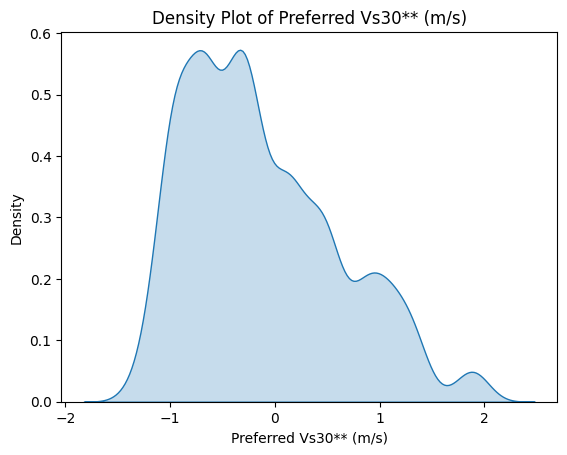

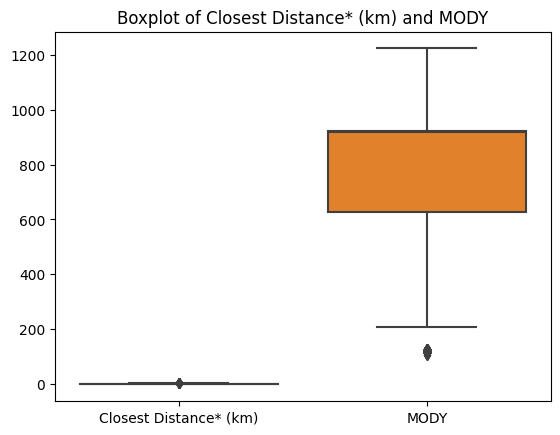

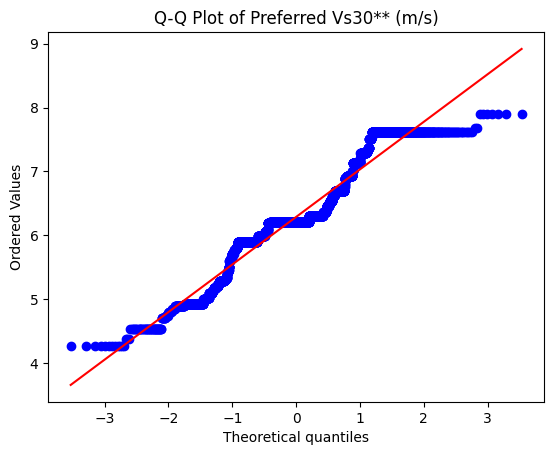

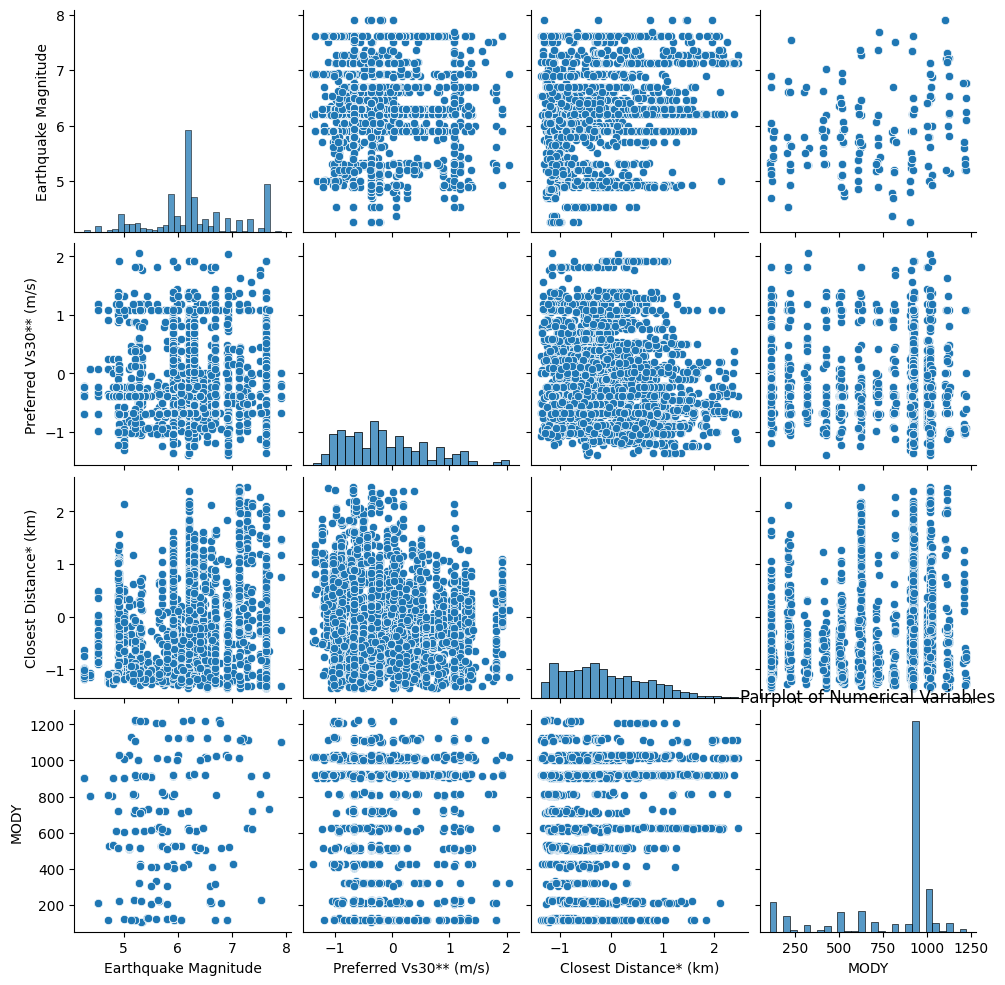

In [ ]:
sns.histplot(data=df['Earthquake Magnitude'], kde=True)
plt.title('Histogram of Earthquake Magnitude')
plt.show()

sns.kdeplot(data=df['Preferred Vs30** (m/s)'], shade=True)
plt.title('Density Plot of Preferred Vs30** (m/s)')
plt.show()

sns.boxplot(data=df[['Closest Distance* (km)', 'MODY']])
plt.title('Boxplot of Closest Distance* (km) and MODY')
plt.show()

# sns.kdeplot(data=df['PCA_Component1'], shade=True)
# plt.title('Density Plot of PCA_Component1')
# plt.show()

# sns.kdeplot(data=df['PCA_Component2'], shade=True)
# plt.title('Density Plot of PCA_Component2')
# plt.show()


import scipy.stats as stats
stats.probplot(df['Earthquake Magnitude'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Preferred Vs30** (m/s)')
plt.show()

sns.pairplot(df[['Earthquake Magnitude', 'Preferred Vs30** (m/s)', 'Closest Distance* (km)', 'MODY']])
plt.title('Pairplot of Numerical Variables')
plt.show()


1951.0       2
1952.0       6
1953.0       1
1954.0       2
1955.0       1
1956.0       1
1957.0       1
1960.0       2
1961.0       2
1966.0       6
1967.0       2
1968.0       2
1970.0      10
1971.0      37
1972.0       7
1973.0       1
1974.0       2
1975.0      20
1976.0      14
1977.0       1
1978.0       8
1979.0      66
1980.0      86
1981.0      15
1983.0     125
1984.0      40
1985.0      12
1986.0      87
1987.0     142
1988.0       1
1989.0      78
1990.0      13
1991.0      13
1992.0     129
1994.0     244
1995.0      40
1997.0       8
1998.0       3
1999.0    1841
2000.0      25
2001.0     134
2002.0      68
2003.0      37
Name: YEAR, dtype: int64

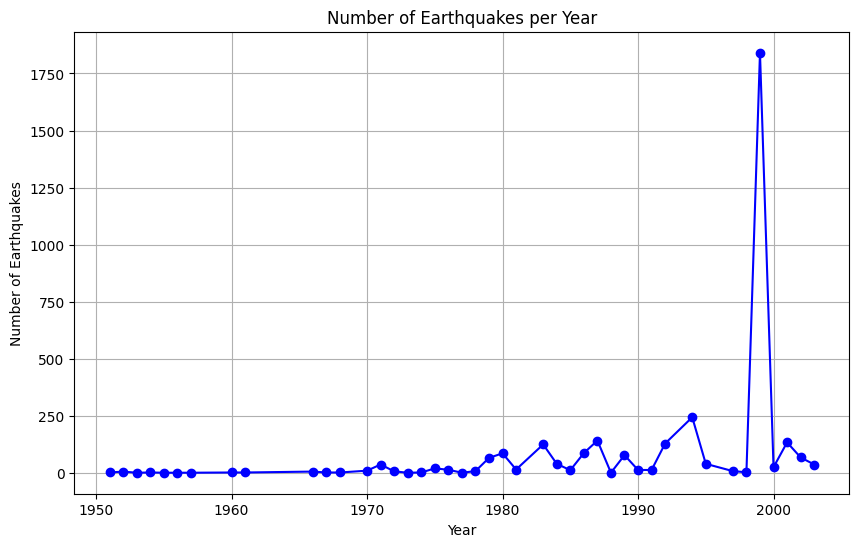

In [ ]:
earthquakes_per_year = df[df['YEAR'] >= 1950]['YEAR'].value_counts().sort_index()
display(earthquakes_per_year)
plt.figure(figsize=(10, 6))
earthquakes_per_year.plot(kind='line', marker='o', color='blue')
plt.title('Number of Earthquakes per Year')
plt.xlabel('Year')
plt.ylabel('Number of Earthquakes')
plt.grid(True)
plt.show()

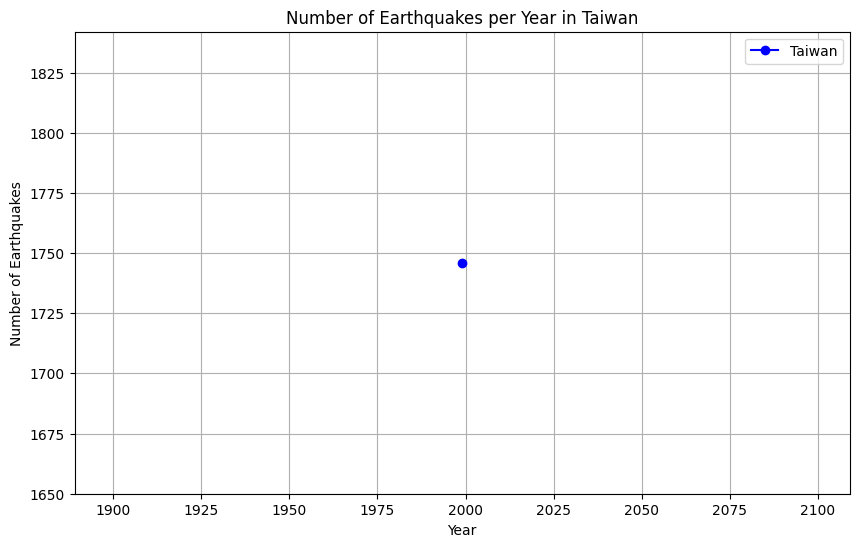

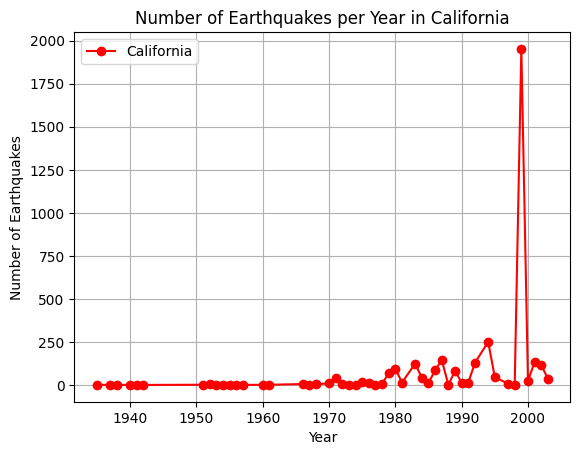

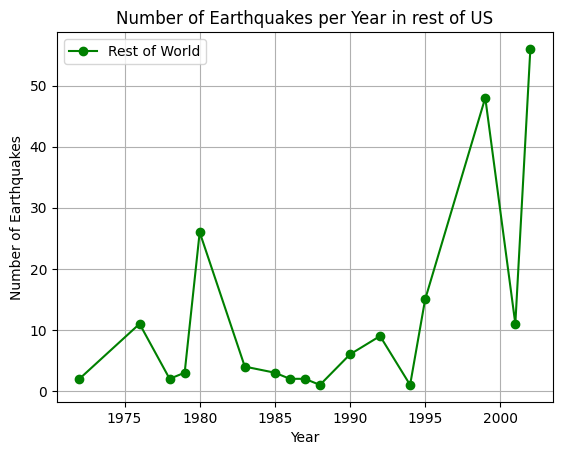

In [ ]:
earthquakes_taiwan = taiwan['YEAR'].value_counts().sort_index()
earthquakes_canada = canada['YEAR'].value_counts().sort_index()
earthquakes_rof = rof['YEAR'].value_counts().sort_index()

plt.figure(figsize=(10, 6))

earthquakes_taiwan.plot(kind='line', marker='o', color='blue', label='Taiwan')
plt.title('Number of Earthquakes per Year in Taiwan')
plt.xlabel('Year')
plt.ylabel('Number of Earthquakes')
plt.legend()
plt.grid(True)
plt.show()

earthquakes_canada.plot(kind='line', marker='o', color='red', label='California')
plt.title('Number of Earthquakes per Year in California')
plt.xlabel('Year')
plt.ylabel('Number of Earthquakes')
plt.legend()
plt.grid(True)
plt.show()

earthquakes_rof.plot(kind='line', marker='o', color='green', label='Rest of World')
plt.title('Number of Earthquakes per Year in rest of US')
plt.xlabel('Year')
plt.ylabel('Number of Earthquakes')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder

data_copy = df.copy()
label_encoder = LabelEncoder()
data_copy['Station Name Encoded'] = label_encoder.fit_transform(data_copy['Station Name'])

float_columns = data_copy.select_dtypes(include='float64').columns
correlation_matrix = data_copy[['Station Name Encoded'] + list(float_columns)].corr()
display(correlation_matrix[['Station Name Encoded']])


,Station Name Encoded
Station Name Encoded,1.000000
Record Sequence Number,0.147631
YEAR,0.098524
MODY,0.009360
Earthquake Magnitude,0.032739
Closest Distance* (km),0.034345
Preferred Vs30** (m/s),0.305589
Strength,0.025343
Intensity,0.307595


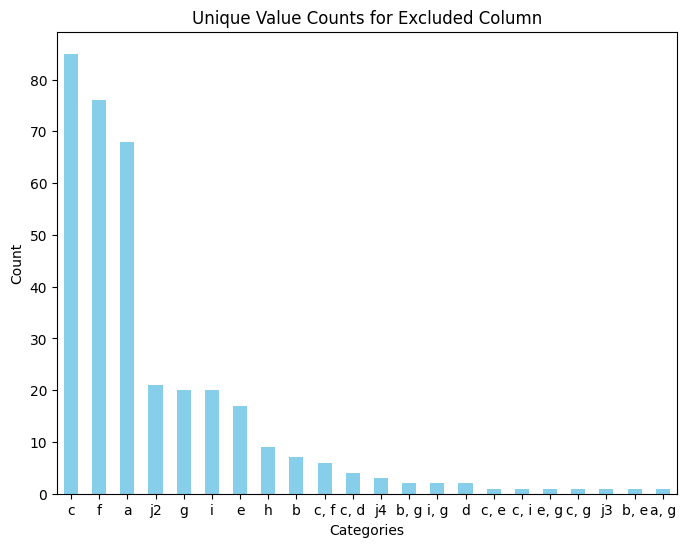

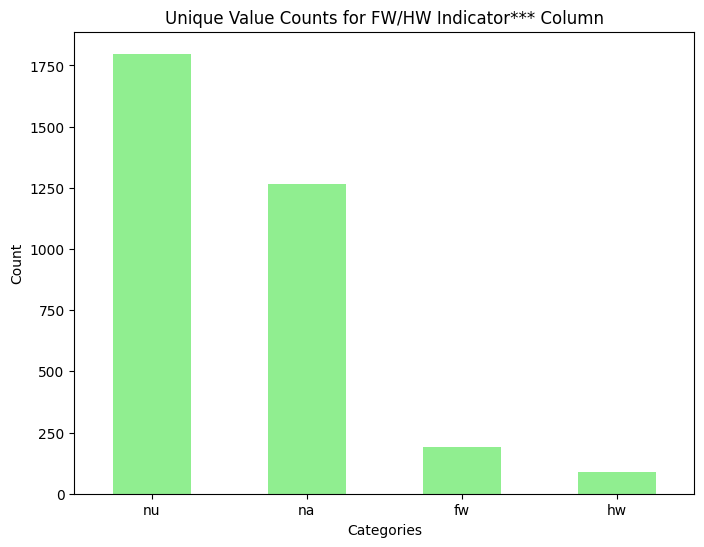

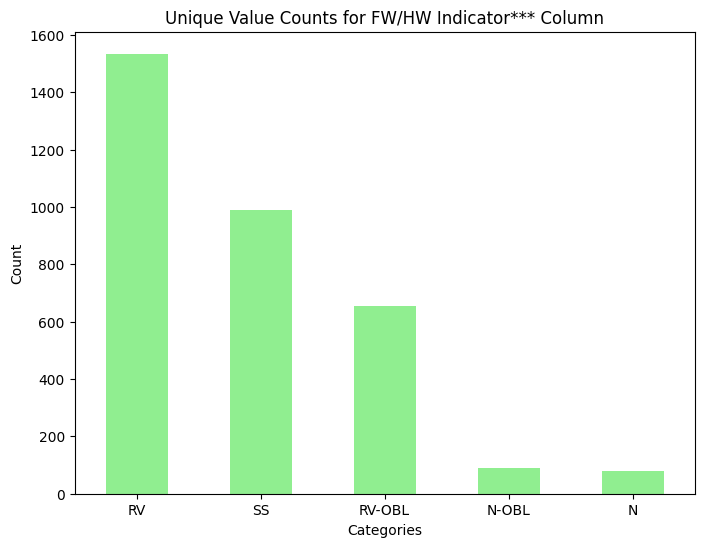

In [ ]:
excluded_unique_counts = df[df['Excluded']!='No']['Excluded'].value_counts()
fwhw_unique_counts = df['FW/HW Indicator***'].value_counts()
faulttype_counts = df['Fault Type'].value_counts()

plt.figure(figsize=(8, 6))
excluded_unique_counts.plot(kind='bar', color='skyblue')
plt.title('Unique Value Counts for Excluded Column')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Plotting bar plot for 'FW/HW Indicator***' column
plt.figure(figsize=(8, 6))
fwhw_unique_counts.plot(kind='bar', color='lightgreen')
plt.title('Unique Value Counts for FW/HW Indicator*** Column')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

plt.figure(figsize=(8, 6))
faulttype_counts.plot(kind='bar', color='lightgreen')
plt.title('Unique Value Counts for FW/HW Indicator*** Column')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

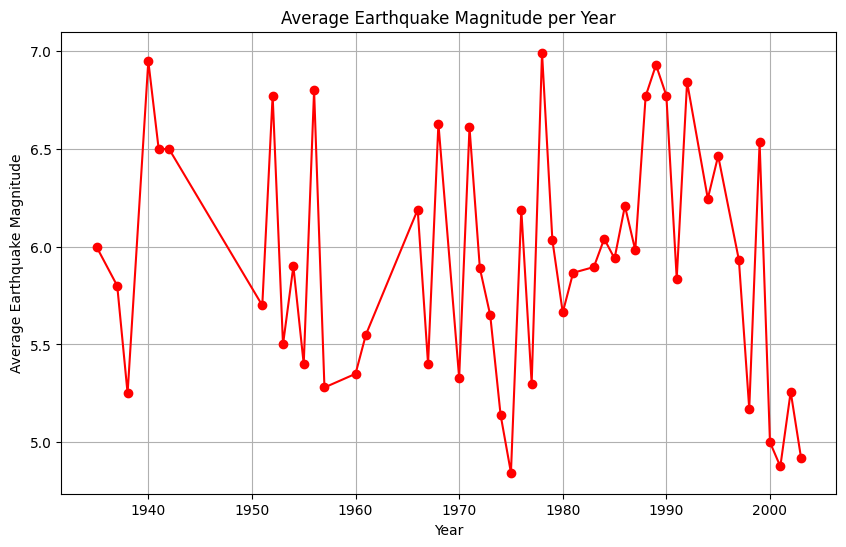

In [ ]:
avg_mag_per_year = df.groupby('YEAR')['Earthquake Magnitude'].mean()
plt.figure(figsize=(10, 6))
avg_mag_per_year.plot(marker='o', color='red')
plt.title('Average Earthquake Magnitude per Year')
plt.xlabel('Year')
plt.ylabel('Average Earthquake Magnitude')
plt.grid(True)
plt.show()

In [ ]:
import plotly.express as px

fig = px.scatter_3d(df, x='Fault Type', y='Earthquake Magnitude', z='Closest Distance* (km)',
                    color='Fault Type', size='Earthquake Magnitude', hover_data=['Fault Type'])

fig.update_layout(title='3D Scatter Plot of Fault Type, Earthquake Magnitude, and Closest Distance',
                  scene=dict(xaxis=dict(title='Fault Type'),
                             yaxis=dict(title='Earthquake Magnitude'),
                             zaxis=dict(title='Closest Distance (km)')))

fig.show()

## **4. DATA MODELLING**

### Predicting Year-wise Earthquake Magnitude, Strength, Intensity Pattern (using regression line since we have observed a timely increase in magnitudes of earthquakes per years)

[(5.275158672130798, 5.813204217408492, 6.3512497626861855, 6.889295307963879, 7.427340853241576, 7.96538639851927, 8.503431943796963, 9.041477489074657, 9.579523034352354), (-19.494524335474864, -9.383821482177837, 0.726881371119191, 10.837584224416219, 20.948287077713246, 31.05898993101033, 41.16969278430736, 51.280395637604386, 61.39109849090141), (-4.39151377247984, -2.4702143318825733, -0.548914891285321, 1.3723845493119313, 3.2936839899091837, 5.21498343050645, 7.1362828711037025, 9.057582311700955, 10.978881752298207)]


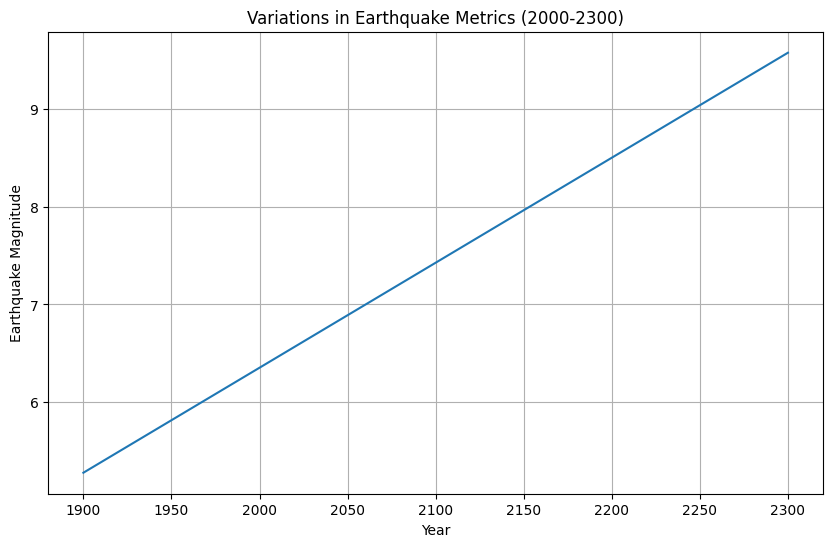

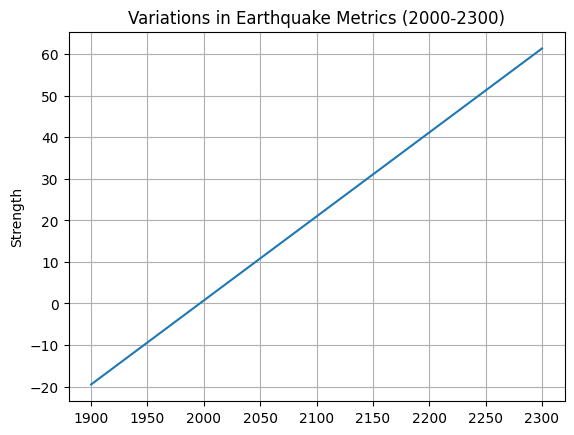

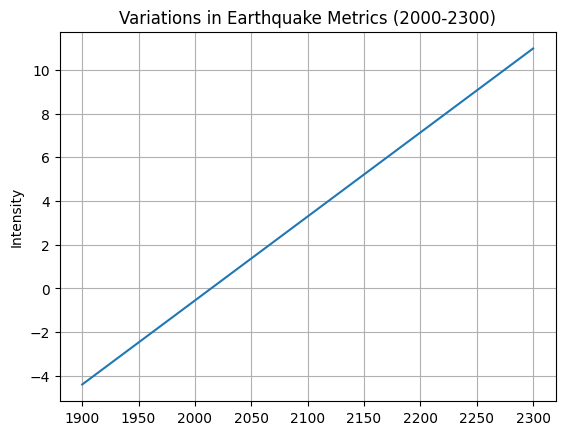

In [ ]:
X = df[['YEAR']]
y = df[['Earthquake Magnitude', 'Strength', 'Intensity']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

years_to_predict = list(range(1900, 2301, 50))
predictions = []

for year in years_to_predict:
    year_input = pd.DataFrame({'YEAR': [year]})
    pred = model.predict(year_input)
    predictions.append(pred[0])

predictions = list(zip(*predictions))
print(predictions)

plt.figure(figsize=(10, 6))
plt.plot(years_to_predict, predictions[0], label='Earthquake Magnitude')
plt.xlabel('Year')
plt.ylabel('Earthquake Magnitude')
plt.title('Variations in Earthquake Metrics (2000-2300)')
plt.grid(True)
plt.show()

plt.plot(years_to_predict, predictions[1], label='Strength')
plt.ylabel('Strength')
plt.title('Variations in Earthquake Metrics (2000-2300)')
plt.grid(True)
plt.show()

plt.plot(years_to_predict, predictions[2], label='Intensity')
plt.ylabel('Intensity')
plt.title('Variations in Earthquake Metrics (2000-2300)')
plt.grid(True)
plt.show()

# desired_year = 2004
# year_input = pd.DataFrame({'YEAR': [desired_year]})

# predictions = model.predict(year_input)

# print(f"Predictions for the year {desired_year}:")
# print("Earthquake Magnitude:", predictions[0][0])
# for i, col in enumerate(y_train.columns[1:], 1):
#     print(f"{col}:", predictions[0][i])

### Preditcing the Earthquake Magnitude per train_test_split

In [ ]:
X = df.drop(columns=['Earthquake Magnitude','Preferred Vs30** (m/s)','Closest Distance* (km)'])
y = df['Earthquake Magnitude']

label_encoders = {}
categorical_cols = ['Station Name', 'Fault Type', 'FW/HW Indicator***', 'Earthquake Name', 'Excluded']
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    X[col] = label_encoders[col].fit_transform(X[col])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (MSE): {mse}")

results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

display(results_df)

Mean Squared Error (MSE): 0.020057133916292897


,Actual,Predicted
1109,7.62,7.6200
2385,6.20,6.2000
1369,5.13,5.1328
1262,7.62,7.6200
1295,7.62,7.6200
...,...,...
1071,7.62,7.6200
1692,4.90,4.9000
3140,6.30,6.3000
336,6.19,5.7653


### **Ensembled Learning with Cross Validation**

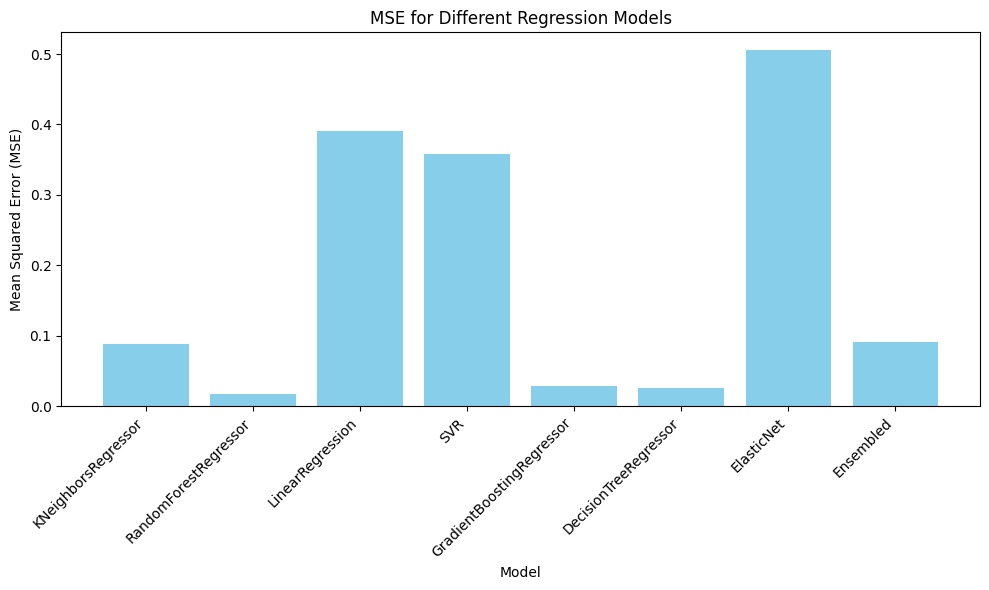

,Model,MSE
0,KNeighborsRegressor,0.088739
1,RandomForestRegressor,0.017478
2,LinearRegression,0.390256
3,SVR,0.357577
4,GradientBoostingRegressor,0.029371
5,DecisionTreeRegressor,0.026598
6,ElasticNet,0.505525
7,Ensembled,0.091158


,Actual Earthquake Magnitude,Predicted KNeighborsRegressor,Predicted RandomForestRegressor,Predicted LinearRegression,Predicted SVR,Predicted GradientBoostingRegressor,Predicted DecisionTreeRegressor,Predicted ElasticNet
0,7.36,4.886,7.1157,5.735621,5.191885,6.735800,7.36,5.960057
1,5.28,6.608,5.2217,5.740639,5.344292,5.304091,5.42,5.582377
2,6.19,5.756,6.1019,5.962428,5.253143,5.984171,6.33,5.997284
3,6.19,5.894,6.1491,5.871367,5.175703,5.775019,6.30,5.977690
4,6.19,5.894,6.2399,5.874569,5.148939,5.765958,5.91,5.951183


In [ ]:
X = df.drop(columns=['Earthquake Magnitude'])
y = df['Earthquake Magnitude']

label_encoders = {}
categorical_cols = ['Station Name', 'Fault Type', 'FW/HW Indicator***', 'Earthquake Name', 'Excluded']
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    X[col] = label_encoders[col].fit_transform(X[col])

models = [
    KNeighborsRegressor(),
    RandomForestRegressor(n_estimators=100, random_state=42),
    LinearRegression(),
    SVR(),
    GradientBoostingRegressor(random_state=42),
    DecisionTreeRegressor(random_state=42),
    ElasticNet(random_state=42)  # Added ElasticNet
]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

model_mse = {}
model_predictions = {}
for model in models:
  predictions = cross_val_predict(model, X, y, cv=kf)
  model_predictions[model.__class__.__name__] = predictions
  mse = mean_squared_error(y, predictions)
  model_mse[model.__class__.__name__] = mse

voting_ensemble = VotingRegressor(estimators=[('model_'+str(i), model) for i, model in enumerate(models)])
ensemble_predictions = cross_val_predict(voting_ensemble, X, y, cv=kf)

ensemble_mse = mean_squared_error(y, ensemble_predictions)
model_mse['Ensembled'] = ensemble_mse
mse_df = pd.DataFrame(list(model_mse.items()), columns=['Model', 'MSE'])

plt.figure(figsize=(10, 6))
plt.bar(mse_df['Model'], mse_df['MSE'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Different Regression Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

display(mse_df)

results = pd.DataFrame()
results['Actual Earthquake Magnitude'] = y

for model_name, predictions in model_predictions.items():
    results[f'Predicted {model_name}'] = predictions

# Displaying the table
display(results.head())

### **Model Performance for Classification**

In [ ]:
models = [
    RandomForestClassifier(n_estimators=100, random_state=42),
    AdaBoostClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    BaggingClassifier(random_state=42),
    ExtraTreesClassifier(random_state=42),
    LogisticRegression(max_iter=1000, random_state=42),
    SGDClassifier(random_state=42),
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=42),
    SVC(random_state=42)
]


X = df.drop(columns=['Fault Type'])
y_fault = df[['Fault Type']]

label_encoder = LabelEncoder()
y_fault = label_encoder.fit_transform(df['Fault Type'])

label_encoders = {}
categorical_cols = ['Station Name', 'FW/HW Indicator***', 'Earthquake Name', 'Excluded']
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    X[col] = label_encoders[col].fit_transform(X[col])

kf = KFold(n_splits=5, shuffle=True, random_state=42)

model_predictions_fault = {}
for model in models:
    predictions = cross_val_predict(model, X, y_fault, cv=kf)
    model_predictions_fault[model.__class__.__name__] = predictions

voting_classifier_fault = VotingClassifier(estimators=[('model_'+str(i), model) for i, model in enumerate(models)])
ensemble_predictions_fault = cross_val_predict(voting_classifier_fault, X, y_fault, cv=kf)

# Calculate accuracy and classification report for each model and ensemble
accuracy_fault = {}
report_fault = {}

for model_name, predictions in model_predictions_fault.items():
    accuracy_fault[model_name] = accuracy_score(y_fault, predictions)
    report_fault[model_name] = classification_report(y_fault, predictions)

accuracy_fault['Ensemble'] = accuracy_score(y_fault, ensemble_predictions_fault)
report_fault['Ensemble'] = classification_report(y_fault, ensemble_predictions_fault)

print("Accuracy for Fault Type prediction:")
for model_name, acc in accuracy_fault.items():
    print(f"{model_name}: {acc}")

print("\nClassification Report for Fault Type prediction:")
for model_name, rep in report_fault.items():
    print(f"{model_name}:\n{rep}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/

Accuracy for Fault Type prediction:
RandomForestClassifier: 0.9898325358851675
AdaBoostClassifier: 0.631877990430622
GradientBoostingClassifier: 0.9895334928229665
BaggingClassifier: 0.9886363636363636
ExtraTreesClassifier: 0.9904306220095693
LogisticRegression: 0.6880980861244019
SGDClassifier: 0.4922248803827751
KNeighborsClassifier: 0.9339114832535885
DecisionTreeClassifier: 0.9880382775119617
SVC: 0.6713516746411483
Ensemble: 0.9883373205741627

Classification Report for Fault Type prediction:
RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        78
           1       0.99      0.92      0.95        89
           2       0.99      1.00      1.00      1534
           3       1.00      0.99      1.00       653
           4       0.98      1.00      0.99       990

    accuracy                           0.99      3344
   macro avg       0.97      0.95      0.96      3344
weighted avg       0.99      0.99      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### **Working with Multioutput Variables**

In [ ]:
models = [
    RandomForestClassifier(n_estimators=100, random_state=42),
    ExtraTreesClassifier(random_state=42),
    KNeighborsClassifier(),
]

X = df.drop(columns=['Fault Type','Excluded'])
y_fault = df[['Fault Type','Excluded']]

label_encoder = LabelEncoder()
y_fault['Fault Type'] = label_encoder.fit_transform(df['Fault Type'])
y_fault['Excluded'] = label_encoder.fit_transform(df['Excluded'])

label_encoders = {}
categorical_cols = ['Station Name', 'FW/HW Indicator***', 'Earthquake Name']
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    X[col] = label_encoders[col].fit_transform(X[col])

kf = KFold(n_splits=5, shuffle=True, random_state=42)

model_predictions_fault = {}
for model in models:
    print(model)
    predictions = cross_val_predict(model, X, y_fault, cv=kf)
    model_predictions_fault[model.__class__.__name__] = predictions

accuracy_fault = {}
report_fault = {}
accuracy_excluded = {}
report_excluded = {}

for model_name, predictions in model_predictions_fault.items():
  accuracy_fault[model_name] = accuracy_score(y_fault['Fault Type'], predictions[:,0])
  report_fault[model_name] = classification_report(y_fault['Fault Type'], predictions[:,0])

print("Accuracy for Fault Type prediction:")
for model_name, acc in accuracy_fault.items():
    print(f"{model_name}: {acc}")

print("\nClassification Report for Fault Type prediction:")
for model_name, rep in report_fault.items():
    print(f"{model_name}:\n{rep}")


for model_name, predictions in model_predictions_fault.items():
  accuracy_excluded[model_name] = accuracy_score(y_fault['Excluded'], predictions[:,0])
  report_excluded[model_name] = classification_report(y_fault['Excluded'], predictions[:,0])

print("Accuracy for Excluded prediction:")
for model_name, acc in accuracy_excluded.items():
    print(f"{model_name}: {acc}")

print("Classification Report for Excluded prediction:")
for model_name, rep in report_excluded.items():
    print(f"{model_name}:\n{rep}")



<ipython-input-77-dacfbaa16589>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-77-dacfbaa16589>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



RandomForestClassifier(random_state=42)
ExtraTreesClassifier(random_state=42)
KNeighborsClassifier()
Accuracy for Fault Type prediction:
RandomForestClassifier: 0.9904306220095693
ExtraTreesClassifier: 0.9913277511961722
KNeighborsClassifier: 0.9339114832535885

Classification Report for Fault Type prediction:
RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86        78
           1       0.99      0.92      0.95        89
           2       1.00      1.00      1.00      1534
           3       1.00      1.00      1.00       653
           4       0.98      1.00      0.99       990

    accuracy                           0.99      3344
   macro avg       0.97      0.95      0.96      3344
weighted avg       0.99      0.99      0.99      3344

ExtraTreesClassifier:
              precision    recall  f1-score   support

           0       0.89      0.86      0.88        78
           1       0.99      0.93      0.96 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` p

## **Conclusion**

This project navigated the Data Science Pipeline to analyze earthquake attributes using machine learning methods applied to historical data. Leveraging concepts from data collection, preprocessing, modeling, and evaluation, the study delved into predicting seismic characteristics like magnitude, intensity, and strength in relation to temporal patterns. Employing models including Linear Regression, Random Forest, and MLP, the analysis unveiled insights into seismic trends over time. By adhering to the Data Science Pipeline, this research contributes to advancing earthquake prediction methodologies, emphasizing the importance of structured data-driven approaches for disaster management and preparedness strategies.

# **END OF PROJECT**